In [1]:
# ! pip install -e ../../savo

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from copy import deepcopy as copy
from scipy import optimize
import torch

import sys
sys.path.append('../')
sys.path.append('../machineIO/')
from savo import savo
from machineIO.utils import plot_2D_projection, dictClass
from machineIO.objFunc import SingleTaskObjectiveFunction
from machineIO.VM import VirtualMachineIO
from machineIO import Evaluator

Failed to import 'epics'
Failed to import 'phantasy'


In [3]:
ndim = 50
budget = 200
ninit = 25  # number of initial ES steps to collect data for surrogate model training
noise = 0.0
max_dx = 1e-2
lr = 1e-2

In [4]:
control_CSETs = [f'X{i}:I_CSET' for i in range(ndim)]
control_RDs   = [f'X{i}:I_RD' for i in range(ndim)]
control_min   = -np.ones(ndim)
control_max   =  np.ones(ndim)
control_maxstep = max_dx*np.ones(ndim)
control_tols  = 1e-3*(control_max-control_min)
control_init = np.random.randn(ndim)*(control_max - control_min) + control_min
monitor_RDs   = [f'Y{i}:I_RD' for i in range(2)]
monitor_min   = -2*np.ones(2)
monitor_max   =  2*np.ones(2)

objective_PVs = monitor_RDs
composite_objective_name = 'rastrigin'

In [5]:
vmio = VirtualMachineIO(
    control_CSETs = control_CSETs,
    control_RDs = control_RDs,
    monitor_RDs = monitor_RDs,
    control_min = control_min,
    control_max = control_max,
    monitor_min = monitor_min,
    monitor_max = monitor_max,
    fetch_data_time_span = 1.0
)
vmio.x = control_init

# obj_func

: rastirigin over 2D latent space of random NN for both high-dim and visualization

In [6]:
def rastrigin(x,noise=noise):
    x = torch.as_tensor(x)
    b,d = x.shape
    y = torch.sum(x**2 - torch.cos(2*np.pi*x),axis=1)/d +1
    return 1-y + torch.randn(b)*noise

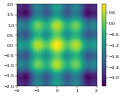

In [7]:
grid = np.linspace(-2,2,128)
x1,x2 = np.meshgrid(grid,grid)
xgrid = np.vstack((x1.flatten(), x2.flatten())).T
ygrid = rastrigin(xgrid,noise=0)
def plot_contour(figsize=(4,3.3),dpi=128):
    fig,ax = plt.subplots(figsize=figsize,dpi=dpi)
    cs = ax.tricontourf(xgrid[:,0],xgrid[:,1],ygrid,levels=32)
    fig.colorbar(cs,ax=ax)
    return fig,ax
fig,ax = plot_contour(dpi=32)

In [8]:
objfunc = SingleTaskObjectiveFunction(
    objective_PVs = monitor_RDs,
    composite_objective_name = composite_objective_name,
    custom_function = rastrigin,
    objective_goal = None, 
    objective_weight = None,
    objective_tolerance = None,
)

In [9]:
evaluator = Evaluator(
    machineIO = vmio,
    control_CSETs = control_CSETs,
    control_RDs = control_RDs,
    control_tols = control_tols,
    monitor_RDs = monitor_RDs,
    df_manipulators = [objfunc.calculate_objectives_from_df],
)

In [11]:
df, _ = evaluator._set_and_read(np.zeros(ndim))
df, _ = evaluator._set_and_read(control_init)
df = evaluator.read()
df[control_CSETs].mean().values - control_init

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.22044605e-16,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -5.55111512e-17,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.22044605e-16,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.22044605e-16,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.22044605e-16,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  5.55111512e-17,  0.00000000e+00,  5.55111512e-17,
        0.00000000e+00,  0.00000000e+00])